# Question 1 du Projet

In [63]:
import pandas as pd
from sklearn import svm
from sklearn import neighbors
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import time
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Lecture et modification des fichiers csv

In [64]:
testA = pd.read_csv(r"representation.testa.csv"  ,  header=None)
testB = pd.read_csv(r"representation.testb.csv"  ,  header=None)
train = pd.read_csv(r"representation.train.csv"  ,  header=None)

true_labels_a=pd.read_csv(r"true_labels.testa.csv"  ,  header=None)
true_labels_b=pd.read_csv(r"true_labels.testb.csv"  ,  header=None)
true_labels_train=pd.read_csv(r"true_labels.train.csv"  ,  header=None)

In [65]:
## Modif des dataframes pour avoir 1 si c'est une personne et 0 sinon
def modif_df(df):
    dataframe=df
    for k in range(len(dataframe)):
        if dataframe[0][k]=="I-PER":
            dataframe[0][k]=1
        else:
            dataframe[0][k]=0
    return dataframe
# complexité linéaire

true_a=modif_df(true_labels_a)
true_b=modif_df(true_labels_b)
true_train=modif_df(true_labels_train)

In [66]:
X_train , Y_train = train, list(true_train[0])
X_test_a , Y_test_a = testA,list(true_a[0])
X_test_b , Y_test_b = testB,list(true_b[0])

### Quelques statistiques sur ces datasets :

In [67]:
nb_train, dim = X_train.shape
nb_test_a,nb_test_b=len(Y_test_a),len(Y_test_b)
nb_noms_train=np.array(Y_train).sum()
nb_noms_test_a=np.array(Y_test_a).sum()
nb_noms_test_b=np.array(Y_test_b).sum()

In [68]:
print("Taille de l'échantillon d'entrainement :", nb_train)
print("Taille de l'échantillon de test :", "a :",nb_test_a, " ,  b :",nb_test_b)
print("Nombre de noms propres dans le train : ",nb_noms_train )
print("Nombre de noms propres dans les tests : ","a :",nb_noms_test_a, " ,  b :",nb_noms_test_b)

Taille de l'échantillon d'entrainement : 10000
Taille de l'échantillon de test : a : 2000  ,  b : 2000
Nombre de noms propres dans le train :  547
Nombre de noms propres dans les tests :  a : 129  ,  b : 130


# Comparaison de différents algorithmes de classification

In [69]:
liste_classifieurs=[LogisticRegression(solver='lbfgs',random_state=0),
                    sklearn.linear_model.RidgeClassifier(alpha=1.0, fit_intercept=True, random_state=0),
                   svm.SVC(),
                    neighbors.KNeighborsClassifier(n_neighbors=10),
                   ]

In [ ]:
def compare_algo(liste_classifieurs,X_train,Y_train,X_test,Y_test):    
    comparaison, temps_train, temps_inf, acc=[],[],[],[]
    for clf in liste_classifieurs:
        t1=time.time()
        clf.fit(X_train , Y_train)
        t2=time.time()
        Y_pred=clf.predict(X_test)
        report=classification_report(Y_test,Y_pred,output_dict=True,target_names=['classe 0', 'classe 1'])
        t3=time.time()
        acc.append(clf.score(X_test,Y_test))
        temps_train.append(t2-t1)
        temps_inf.append(t3-t2)
        comparaison.append(pd.DataFrame(report)['classe 1'])
    df_comparaison=pd.DataFrame(comparaison,index=['Regression Logistique','Regression Linéaire','SVM','KNN'])
    df_comparaison['temps train (s)']=temps_train
    df_comparaison['temps inference (s)']=temps_inf
    df_comparaison['accuracy']=acc
    return df_comparaison [['accuracy','precision','recall','f1-score','temps train (s)','temps inference (s)']]

## Comparaison sur le test A :

In [ ]:
compare_algo(liste_classifieurs,X_train, Y_train, X_test_a, Y_test_a)

## Comparaison sur le test B :

In [ ]:
compare_algo(liste_classifieurs,X_train, Y_train, X_test_b, Y_test_b)

Au vu des résultats, les régressions logistique et linéaire sont les classifieurs qui donnent les meilleurs résultats. Nous allons les étudierplus précisément et les départager dans la partie suivante.

# Etude plus poussée des régressions logistique et linéaire :

In [73]:
log = LogisticRegression(solver='lbfgs',random_state=0).fit(X_train , Y_train)
lin=sklearn.linear_model.RidgeClassifier(alpha=1.0, fit_intercept=True, random_state=0).fit(X_train,Y_train)

### Matrices de confusion :

In [74]:
Y_pred_log_a=log.predict(X_test_a)
Y_pred_log_b=log.predict(X_test_b)
Y_pred_lin_a=lin.predict(X_test_a)
Y_pred_lin_b=lin.predict(X_test_b)

In [75]:
def print_confusion(matrice):
    df=pd.DataFrame(matrice, index = ['classe negative', 'classe positive'],
                    columns = ['prédit negatif', 'prédit positif'])
    print(df,"\n")

In [76]:
print("TEST A : \n")
print("Regression logistique : \n")
print_confusion(confusion_matrix(Y_test_a,Y_pred_log_a))
print("Regression linéaire : \n")
print_confusion(confusion_matrix(Y_test_a,Y_pred_lin_a))
print('--'*20,'\n\n')
print("TEST B : \n")
print("Regression logistique : \n")
print_confusion(confusion_matrix(Y_test_b,Y_pred_log_b))
print("Regression linéaire : \n")
print_confusion(confusion_matrix(Y_test_b,Y_pred_lin_b))

TEST A : 

Regression logistique : 

                 prédit negatif  prédit positif
classe negative            1863               8
classe positive              21             108 

Regression linéaire : 

                 prédit negatif  prédit positif
classe negative            1870               1
classe positive              34              95 

---------------------------------------- 


TEST B : 

Regression logistique : 

                 prédit negatif  prédit positif
classe negative            1856              14
classe positive              30             100 

Regression linéaire : 

                 prédit negatif  prédit positif
classe negative            1868               2
classe positive              35              95 



Il faut alors comprendre ce qui est le plus important. Pour nous, le pire serait d'avoir un problème avec la justice d'un pays car nous n'avons pas anonimisé un nom. C'est donc la case "Faux négatif" qu'il faut minimiser, et pour cela, la regression logistique est meilleure. C'est donc elle que nous implémenterons en C++. 
De plus, nous traçons ci-après la courbe ROC de cette regression logistique.

### Courbe ROC :

In [77]:
Y_score_a =log.decision_function(X_test_a)

In [78]:
fpr, tpr, _ = roc_curve(Y_test_a, Y_score_a)
roc_auc = auc(fpr, tpr)

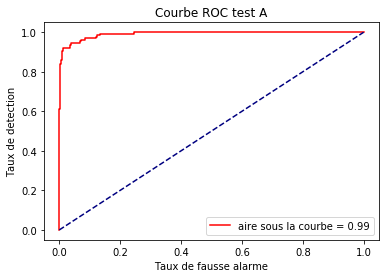

In [83]:
plt.figure()
plt.plot(fpr, tpr, color='red', label='aire sous la courbe = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Taux de fausse alarme')
plt.ylabel('Taux de detection')
plt.title('Courbe ROC test A')
plt.legend(loc="lower right")
plt.show()

# On rajoute une petite étude de réduction de la dimension (PAS REVUE ENCORE, PLUS TARD)

In [6]:
###########################################################
##    PCA
###########################################################

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(train)
print("variance expliquée avec ces features seulement : ")
print(pca.explained_variance_ratio_.sum())
print("nombre total de features : ", len(train.columns))

variance expliquée avec ces features seulement : 
0.17222365780066243
nombre total de features :  1024


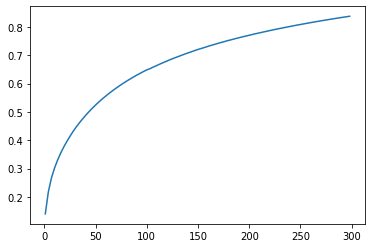

on voit que 300 features ca explique deja pas mal.


In [7]:
abs=[]
ord=[]

for k in range(1,300,3):
    pca = PCA(n_components=k)
    pca.fit(train)
    abs.append(k)
    ord.append(pca.explained_variance_ratio_.sum())

import matplotlib.pyplot as plt

plt.plot(abs,ord)
plt.show()
print("on voit que 300 features ca explique deja pas mal.")

In [8]:
pca_train=pca.fit_transform(train,list(true_train))
pca_a=pca.transform(testA)
pca_b=pca.transform(testB)

clf = LogisticRegression(random_state=0).fit(pca_train, list(true_train[0]))
print("score de la regression avec 2 composantes PCA seulement : ")
print("test A : ", clf.score(pca_a,list(true_a[0])))
print("test B : ", clf.score(pca_b,list(true_b[0])))

C:\Users\danbe\Anaconda3\envs\dalet_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


score de la regression avec 2 composantes PCA seulement : 
test A :  0.981
test B :  0.982
